# Generative Model for SVHN Image and Label Synthesis Evaluation

This notebook will be used for evaluationg your model. Your task is to complete the model definition and generator function cell. You need to copy over you model definition, load the weights, and make sure that the generator function is generating the data in the correct format.

The generator models are evaluated by training a fixed classifier on their generated data, and measuring the classifier performance on an evaluation dataset. You **CANNOT** modify the classifier or its training. The classifier is trained with 3 seeds. The 3 seeds are going to be changed for the final evaluation and the leaderboard to avoid overfitting to these seeds.



## Tasks:
   - Define a class for your generative model.
   - Load the weights you have trained into this model from your checkpoint.
   - If needed, you can modify the function named `generate` to work with your model.

## Generator function:
You can modify the `generate`, but it should satisfy the the follwing properties.
- **Input:**
   - number of samples

- **Output:**
   - A floating-point image matrix of size `(n_samples x 3 x 32 x 32)` in the range of [0,1].
   - An integer label matrix of size `(n_samples x 1)` in the range of 0 to 9.

- **Perfomrance constraint:**
   - Ensure the generation of 1000 samples within 3 seconds on the snowflake cluster or colab.
   - Stay within a maximum of 10GB of GPU memory.

## Important

- **Fixed classifier:**  You can only modify the model definition and generator function cell.
- **Data:**  Do not load any external data.
- **Models:**  Do not load externaly pre-trained (not by you for this hackathon) models.



Follow the provided structure, and make sure to comply with the outlined requirements. The success of your submission depends on the effectiveness of your generator function and the ability of your model to produce realistic SVHN images with accurate labels. Highest classifier accuracy wins.

Submission instructions in the main notebook.


In [2]:
team_members = ['Ming-Han Lee', 'Chia-Wen Chen']
assert len(team_members) > 0

### Imports

In [1]:
import os
import time
import numpy as np
from tqdm import tqdm
from google.colab import drive
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import SVHN
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

### Model definition and generator function

You can modify this cell. Complete the generate function to sample data from your model output.

In [4]:
# Model definition and generator function, you should modify this
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Networks
def conv_block(c_in, c_out, k_size=4, stride=2, pad=1, use_bn=True, transpose=False):
    module = []
    if transpose:
        module.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, pad, bias=not use_bn))
    else:
        module.append(nn.Conv2d(c_in, c_out, k_size, stride, pad, bias=not use_bn))
    if use_bn:
        module.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*module)

class Generator(nn.Module):
    def __init__(self, z_dim=10, num_classes=10, label_embed_size=5, channels=3, conv_dim=64):
        super(Generator, self).__init__()
        self.num_classes = num_classes
        self.z_dim = z_dim
        self.label_embedding = nn.Embedding(num_classes, label_embed_size)
        self.tconv1 = conv_block(z_dim + label_embed_size, conv_dim * 4, pad=0, transpose=True)
        self.tconv2 = conv_block(conv_dim * 4, conv_dim * 2, transpose=True)
        self.tconv3 = conv_block(conv_dim * 2, conv_dim, transpose=True)
        self.tconv4 = conv_block(conv_dim, channels, transpose=True, use_bn=False)

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.normal_(m.weight, 0.0, 0.02)

            if isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x, label):
        x = x.reshape([x.shape[0], -1, 1, 1])
        label_embed = self.label_embedding(label)
        label_embed = label_embed.reshape([label_embed.shape[0], -1, 1, 1])
        x = torch.cat((x, label_embed), dim=1)
        x = F.relu(self.tconv1(x))
        x = F.relu(self.tconv2(x))
        x = F.relu(self.tconv3(x))
        x = torch.tanh(self.tconv4(x))
        return x

    def generate(self, n_samples=1000, device=device):
        labels = torch.randint(0, self.num_classes, (n_samples,)).to(device)
        z_fake = torch.randn((n_samples, self.z_dim), dtype=torch.float).to(device)
        fake_imgs = self.forward(z_fake, labels)
        fake_imgs = (fake_imgs + 1) / 2

        return fake_imgs, labels



generator_model = Generator().to(device)
model_path = ''
generator_model.load_state_dict(torch.load(os.path.join(model_path, 'checkpoints.pkl')))

# # Load checkpoint on Google Drive
# drive.mount('/content/gdrive', force_remount=True)
# checkpoint_path = '/content/gdrive/MyDrive/path_to_model.pth'
# checkpoint = torch.load(checkpoint_path)
# generator_model.load_state_dict(checkpoint['model_state_dict'])


def generate(n_samples=1000): # WHY NOT JUST USE THE GENERATE FUNCTION IN THE CLASS? THIS IS DONE IN THE TRA
    generator_model.eval()
    images, labels = generator_model.generate(n_samples, device=device)
    return images, labels

### Speed test

Testing if your model can sample at the required speed. If you are over the limit, then please simplify your model.

In [5]:
num_runs = 10

start_time = time.time()
for _ in range(num_runs):
    generate(n_samples=1000)
end_time = time.time()

average_time = (end_time - start_time) / num_runs
print(f"Average time per execution: {average_time:.6f} seconds")
if device == "cpu":
    print("Running on the CPU can make generating samples slower")
assert average_time <= 3, "Your generator is too slow (takes more than 3s to generate 1000 samples)"

Average time per execution: 0.164822 seconds


### Visualizing samples from your model

In [ ]:
num_samples = 50
images, labels = generate(n_samples=num_samples)

fig = plt.figure(figsize=(20, 10))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 10), axes_pad=0.3)

for ax, im, label in zip(grid, images, labels):
    im = im.permute(1, 2, 0)
    im = im.detach().cpu().numpy()
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(f'{label.item()}')

plt.show()

## Classifier - DO **NOT** MODIFY ANY OF THESE CELLS

### Classifier definition

In [6]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        # Convolutional layers
        self.conv_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(3, 32, kernel_size=(3, 3), padding=(1, 1)),
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.Dropout2d(p=0.0),
                nn.MaxPool2d(kernel_size=(2, 2))
            ),
            nn.Sequential(
                nn.Conv2d(32, 64, kernel_size=(3, 3), padding=(1, 1)),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.Dropout2d(p=0.0),
                nn.MaxPool2d(kernel_size=(2, 2))
            ),
            nn.Sequential(
                nn.Conv2d(64, 64, kernel_size=(3, 3), padding=(1, 1)),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.Dropout2d(p=0.0),
                nn.MaxPool2d(kernel_size=(2, 2))
            )
        ])

        # Flatten
        self.flatten = nn.Flatten()

        # Linear layers
        self.linear_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Linear(64 * 4 * 4, 64),
                nn.Dropout(p=0.0),
                nn.ReLU()
            ),
            nn.Sequential(
                nn.Linear(64, 10),
                nn.Dropout(p=0.0),
                nn.LogSoftmax(dim=1)
            )
        ])

    def forward(self, x):
        for conv_block in self.conv_blocks:
            x = conv_block(x)
        x = self.flatten(x)
        for linear_block in self.linear_blocks:
            x = linear_block(x)
        return x

### Training and evaluation functions

In [7]:
def train_one_epoch(classifier, optimizer, loss_fn, num_iters=100):
    classifier.train()
    train_losses_epoch, train_accs_epoch = [], []
    progress_bar = tqdm(range(num_iters), desc='Training')

    for _ in progress_bar:
        images, labels = generate()
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = classifier(images)
        loss = loss_fn(logits, labels)

        loss.backward()
        optimizer.step()

        train_losses_epoch.append(loss.item())
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        labels = labels.cpu().numpy()
        train_accs_epoch.append(accuracy_score(preds, labels))

    train_loss_epoch = sum(train_losses_epoch) / len(train_losses_epoch)
    train_acc_epoch = sum(train_accs_epoch) / len(train_accs_epoch)

    return train_loss_epoch, train_acc_epoch

def evaluate(model, test_loader, loss_fn):
    model.eval()
    true_values, pred_values = [], []
    losses = []
    for batch in test_loader:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            logits = model(images)
            loss = loss_fn(logits, labels)
        losses.append(loss.item())
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        labels = labels.cpu().numpy()

        true_values.extend(labels.tolist())
        pred_values.extend(preds.tolist())

    accuracy = accuracy_score(pred_values, true_values)
    loss = sum(losses) / len(losses)
    return true_values, pred_values, loss, accuracy

def plot_training_curves(train_losses, train_accs, val_losses, val_accs):
    plt.subplot(2, 1, 1)
    plt.plot(np.arange(len(train_losses))+1, train_losses, label="train")
    plt.plot(np.arange(len(val_losses))+1, val_losses, label="valid")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend(loc="best")

    plt.subplot(2, 1, 2)
    plt.plot(np.arange(len(train_accs))+1, train_accs, label="train")
    plt.plot(np.arange(len(val_accs))+1, val_accs, label="valid")
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.legend(loc="best")

    plt.tight_layout()
    plt.show()

### Running training and evaluation with 3 seeds

Training: 100%|██████████| 100/100 [00:10<00:00,  9.28it/s]


Epoch  1 | Train Loss: 1.255, Accuracy: 61.79% | Validation Loss: 1.281, Accuracy: 62.87%


Training: 100%|██████████| 100/100 [00:08<00:00, 11.35it/s]


Epoch  2 | Train Loss: 0.228, Accuracy: 94.91% | Validation Loss: 1.373, Accuracy: 64.70%


Training: 100%|██████████| 100/100 [00:08<00:00, 11.48it/s]


Epoch  3 | Train Loss: 0.067, Accuracy: 98.73% | Validation Loss: 1.355, Accuracy: 66.91%


Training: 100%|██████████| 100/100 [00:08<00:00, 11.43it/s]


Epoch  4 | Train Loss: 0.032, Accuracy: 99.42% | Validation Loss: 1.586, Accuracy: 63.58%


Training: 100%|██████████| 100/100 [00:08<00:00, 11.27it/s]


Epoch  5 | Train Loss: 0.021, Accuracy: 99.61% | Validation Loss: 1.523, Accuracy: 65.02%


Training: 100%|██████████| 100/100 [00:08<00:00, 11.13it/s]


Epoch  6 | Train Loss: 0.015, Accuracy: 99.71% | Validation Loss: 1.569, Accuracy: 64.65%


Training: 100%|██████████| 100/100 [00:09<00:00, 11.03it/s]


Epoch  7 | Train Loss: 0.011, Accuracy: 99.79% | Validation Loss: 1.925, Accuracy: 60.10%


Training: 100%|██████████| 100/100 [00:09<00:00, 10.91it/s]


Epoch  8 | Train Loss: 0.008, Accuracy: 99.85% | Validation Loss: 1.663, Accuracy: 63.83%


Training: 100%|██████████| 100/100 [00:09<00:00, 10.86it/s]


Epoch  9 | Train Loss: 0.007, Accuracy: 99.86% | Validation Loss: 1.578, Accuracy: 65.09%


Training: 100%|██████████| 100/100 [00:09<00:00, 10.88it/s]


Epoch 10 | Train Loss: 0.007, Accuracy: 99.86% | Validation Loss: 2.060, Accuracy: 58.77%


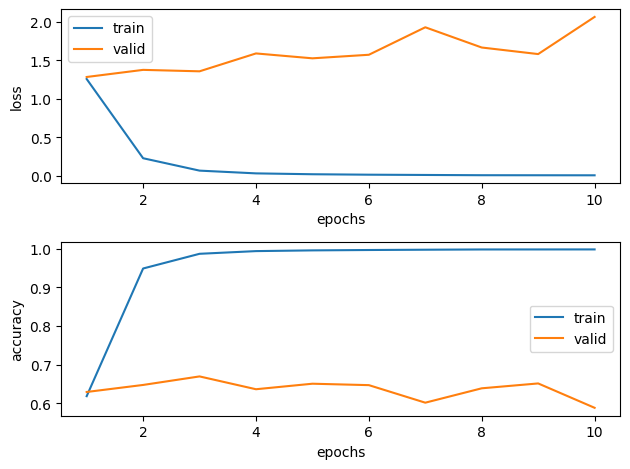

Training: 100%|██████████| 100/100 [00:09<00:00, 10.94it/s]


Epoch  1 | Train Loss: 1.355, Accuracy: 57.49% | Validation Loss: 1.200, Accuracy: 62.20%


Training: 100%|██████████| 100/100 [00:09<00:00, 10.99it/s]


Epoch  2 | Train Loss: 0.237, Accuracy: 94.38% | Validation Loss: 1.575, Accuracy: 61.25%


Training: 100%|██████████| 100/100 [00:09<00:00, 10.86it/s]


Epoch  3 | Train Loss: 0.079, Accuracy: 98.38% | Validation Loss: 1.929, Accuracy: 59.63%


Training: 100%|██████████| 100/100 [00:09<00:00, 11.00it/s]


Epoch  4 | Train Loss: 0.039, Accuracy: 99.24% | Validation Loss: 1.896, Accuracy: 59.27%


Training: 100%|██████████| 100/100 [00:09<00:00, 10.78it/s]


Epoch  5 | Train Loss: 0.024, Accuracy: 99.55% | Validation Loss: 2.103, Accuracy: 58.60%


Training: 100%|██████████| 100/100 [00:09<00:00, 10.88it/s]


Epoch  6 | Train Loss: 0.018, Accuracy: 99.65% | Validation Loss: 2.015, Accuracy: 59.09%


Training: 100%|██████████| 100/100 [00:09<00:00, 10.91it/s]


Epoch  7 | Train Loss: 0.013, Accuracy: 99.72% | Validation Loss: 2.235, Accuracy: 56.40%


Training: 100%|██████████| 100/100 [00:09<00:00, 10.96it/s]


Epoch  8 | Train Loss: 0.011, Accuracy: 99.76% | Validation Loss: 2.165, Accuracy: 57.74%


Training: 100%|██████████| 100/100 [00:09<00:00, 11.02it/s]


Epoch  9 | Train Loss: 0.009, Accuracy: 99.79% | Validation Loss: 2.125, Accuracy: 57.09%


Training: 100%|██████████| 100/100 [00:09<00:00, 10.95it/s]


Epoch 10 | Train Loss: 0.008, Accuracy: 99.82% | Validation Loss: 2.538, Accuracy: 55.59%


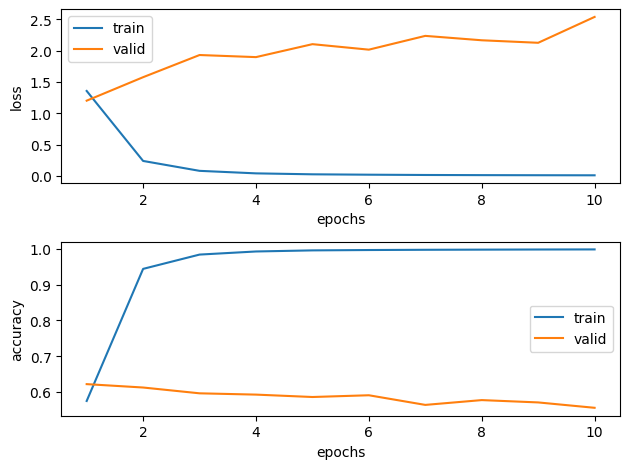

Training: 100%|██████████| 100/100 [00:09<00:00, 10.90it/s]


Epoch  1 | Train Loss: 1.454, Accuracy: 54.17% | Validation Loss: 1.427, Accuracy: 58.14%


Training: 100%|██████████| 100/100 [00:09<00:00, 10.92it/s]


Epoch  2 | Train Loss: 0.237, Accuracy: 94.78% | Validation Loss: 1.494, Accuracy: 61.01%


Training: 100%|██████████| 100/100 [00:09<00:00, 10.95it/s]


Epoch  3 | Train Loss: 0.067, Accuracy: 98.70% | Validation Loss: 1.633, Accuracy: 60.38%


Training: 100%|██████████| 100/100 [00:09<00:00, 10.95it/s]


Epoch  4 | Train Loss: 0.033, Accuracy: 99.37% | Validation Loss: 1.655, Accuracy: 60.05%


Training: 100%|██████████| 100/100 [00:09<00:00, 10.96it/s]


Epoch  5 | Train Loss: 0.021, Accuracy: 99.58% | Validation Loss: 1.704, Accuracy: 61.17%


Training: 100%|██████████| 100/100 [00:09<00:00, 10.96it/s]


Epoch  6 | Train Loss: 0.015, Accuracy: 99.70% | Validation Loss: 1.785, Accuracy: 61.14%


Training: 100%|██████████| 100/100 [00:09<00:00, 10.94it/s]


Epoch  7 | Train Loss: 0.012, Accuracy: 99.72% | Validation Loss: 1.890, Accuracy: 58.06%


Training: 100%|██████████| 100/100 [00:09<00:00, 10.91it/s]


Epoch  8 | Train Loss: 0.011, Accuracy: 99.76% | Validation Loss: 1.908, Accuracy: 58.37%


Training: 100%|██████████| 100/100 [00:09<00:00, 10.97it/s]


Epoch  9 | Train Loss: 0.008, Accuracy: 99.86% | Validation Loss: 1.843, Accuracy: 58.78%


Training: 100%|██████████| 100/100 [00:09<00:00, 10.95it/s]


Epoch 10 | Train Loss: 0.007, Accuracy: 99.85% | Validation Loss: 2.011, Accuracy: 58.65%


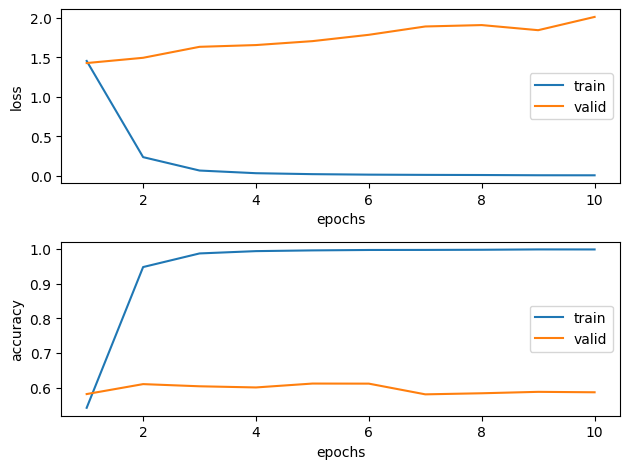

Final score: validation accuracy over 3 seeds| mean: 57.6675% | std: 1.4730%


In [8]:
transform = transforms.ToTensor()
test_dataset = SVHN(root='~/datasets', split='test', transform=transform, download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

def run_experiment(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

    classifier = Classifier().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(classifier.parameters(), lr=0.001)

    NUM_EPOCHS = 10
    train_losses, train_accs, val_losses, val_accs = [], [], [], []
    for epoch in range(1, NUM_EPOCHS + 1):
        # Training
        train_loss_epoch, train_acc_epoch = train_one_epoch(classifier, optimizer, loss_fn)

        # Validation
        true_values, pred_values, val_loss_epoch, val_acc_epoch = evaluate(classifier, test_loader, loss_fn)

        print(f"Epoch {epoch:2d} | Train Loss: {train_loss_epoch:.3f}, Accuracy: {train_acc_epoch * 100:.2f}% | Validation Loss: {val_loss_epoch:.3f}, Accuracy: {val_acc_epoch * 100:.2f}%")
        train_losses.append(train_loss_epoch)
        train_accs.append(train_acc_epoch)
        val_losses.append(val_loss_epoch)
        val_accs.append(val_acc_epoch)

    plot_training_curves(train_losses, train_accs, val_losses, val_accs)
    return val_accs[-1]

num_seeds = 3
val_accuracies = [run_experiment(seed) for seed in range(num_seeds)]
print(f"Final score: validation accuracy over {num_seeds} seeds| mean: {np.mean(val_accuracies) * 100:.4f}% | std: {np.std(val_accuracies) * 100:.4f}%")